# Plotting: Models

This notebook is used to generate all the "model" plots (results and analysis on trained models) in the paper.

## Setup

In [120]:
plot_dir = "../plots/models/"
data_base = "../data"
save_dir = data_base + "/models"

resolution = 1000 # Number of threshold steps to plot

num_samples = 11000
seed = 20220615

shuffle_buffer_sample = 1000
group_window_size = 4
batch_size = 32
num_batches = 100

group_window_size_bigbatch = 64
num_batches_bigbatch = 500

In [2]:
import os
import functools
from tqdm import tqdm
import datetime
from sklearn.model_selection import ShuffleSplit

from util.data import TFRecordLoader
from util.models import SimpleTripletSplitConvModel, AETripletSplitConvModel

import sqlite3
import base64

2023-05-04 14:15:52.809744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from matplotlib.colors import LogNorm # For plotting with log-scaled colormaps

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

#palette = 'colorblind'
colors = [
    (190, 15, 52),
    (72, 145, 220),
    (0, 119, 112),
    (207, 122, 48),
    (235, 196, 203),
]
colors_hex = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

colors_gradient = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in 
    [
        (235, 196, 203),
        (190, 15, 52),
        (135, 36, 52)
    ]
]
colors_gradient_str = ','.join(colors_gradient)
palette_gradient = sns.color_palette(f"blend:{colors_gradient_str}", as_cmap=True)

colors_gradient_blue = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (158, 206, 235),
        (72, 145, 220),
        (0, 33, 71),
    ]
]
colors_gradient_str_blue = ','.join(colors_gradient_blue)
palette_gradient_blue = sns.color_palette(f"blend:{colors_gradient_str_blue}", as_cmap=True)

sns.set_theme(palette=colors_hex, color_codes=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.color_palette(colors_hex)

plt.rcParams['figure.dpi'] = 72

## Helpers: Data

Functions for loading and preprocessing data for each plot.

In [5]:
datasets = [
    dict(
        name='shuffled',
        label='Base Dataset',
        file='tfrecord-shuffled/data-8.tfrecord'
    ),
    dict(
        name='ids-removed-train',
        label='IDs Removed (Train)',
        file='tfrecord-ids-removed/train/data-19.tfrecord'
    ),
    dict(
        name='ids-removed-test',
        label='IDs Removed (Test)',
        file='tfrecord-ids-removed/test/data-0.tfrecord'
    ),
]

datasets_magnitude = [
    dict(
        name=f'magnitude-{magnitude}',
        label=f'{magnitude}%',
        file=f'noise/tfrecord-magnitude/{magnitude}/data-{file_num}.tfrecord'
    )
    for magnitude, file_num in [
        (10, 2),
        (20, 4),
        (30, 6),
        (40, 8),
        (50, 10),
        (60, 12),
        (70, 14),
        (80, 16),
        (90, 18),
    ]
]

datasets = datasets + datasets_magnitude

In [148]:
def get_dataset_batch(dataset, downsampling=None, bigbatch=False):
    """
    Returns a batch of samples from the given dataset.

    Args:
        dataset (dict or str): Dataset to get batch from.
        downsampling (int, optional): Downsampling factor to apply to samples.
        bigbatch (bool, optional): Whether to return a larger batch with more messages from each transmitter.

    Returns:
        samples (np.ndarray): Batch of samples.
        labels (np.ndarray): Batch of labels.
    """
    if isinstance(dataset, str):
        dataset = next(d for d in datasets if d['name'] == dataset)
    elif isinstance(dataset, dict):
        pass
    else:
        raise ValueError(f"Invalid dataset: {dataset}")

    file_data = os.path.join(data_base, dataset['file'])

    ds = TFRecordLoader.from_file(file_data, shuffle_buffer_sample, seed)
    if downsampling is not None:
        ds = ds.map(lambda x, y: (x[::downsampling], y))
    if bigbatch:
        ds = TFRecordLoader.window_batch(ds, group_window_size_bigbatch, batch_size)
    else:
        ds = TFRecordLoader.window_batch(ds, group_window_size, batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    samples = []
    labels = []
    n = num_batches_bigbatch if bigbatch else num_batches
    for i, (x, y) in enumerate(ds.take(n)):
        if i == num_batches:
            break
        samples.append(x.numpy())
        labels.append(y.numpy())

    samples = np.concatenate(samples)
    labels = np.concatenate(labels)

    if bigbatch:
        labels_unique, labels_counts = np.unique(labels, return_counts=True)
        samples_filter = samples[np.isin(labels, labels_unique[labels_counts > (group_window_size_bigbatch // 2)])]
        labels_filter = labels[np.isin(labels, labels_unique[labels_counts > (group_window_size_bigbatch // 2)])]
        samples = samples_filter
        labels = labels_filter

    del ds

    return samples, labels

def get_dataset_all(dataset, downsampling=None):
    """
    Returns the entirety of the given dataset.

    Args:
        dataset (dict or str): Dataset to load.
        downsampling (int, optional): Downsampling factor to apply to samples.

    Returns:
        samples (np.ndarray): Batch of samples.
        labels (np.ndarray): Batch of labels.
    """
    if isinstance(dataset, str):
        dataset = next(d for d in datasets if d['name'] == dataset)
    elif isinstance(dataset, dict):
        pass
    else:
        raise ValueError(f"Invalid dataset: {dataset}")

    file_data = os.path.join(data_base, dataset['file'])

    ds = TFRecordLoader.from_file(file_data, shuffle_buffer_sample, seed)
    if downsampling is not None:
        ds = ds.map(lambda x, y: (x[::downsampling], y))

    samples = []
    labels = []
    for i, (x, y) in enumerate(ds):
        samples.append(x.numpy())
        labels.append(y.numpy())

    samples = np.array(samples)
    labels = np.array(labels)

    del ds

    return samples, labels

## Helpers: Models

Functions for loading and unloading models and their checkpoints.

In [7]:
models = [
    dict(
        name='ae-triplet',
        label='Base Model',
        autoencoder=True,
        downsampling=None,
        dataset='shuffled',
    ),
    dict(
        name='ae-triplet-ids-removed',
        label='IDs Removed',
        autoencoder=True,
        downsampling=None,
        dataset='ids-removed-train',
    ),
]

models_magnitude = [
    dict(
        name=f'ae-triplet-magnitude-{magnitude}',
        label=f'{magnitude}%',
        percentage=magnitude,
        autoencoder=True,
        downsampling=None,
        dataset=f'magnitude-{magnitude}',
    )
    for magnitude in [10, 20, 30, 40, 50, 60, 70, 80, 90]
]

models = models + models_magnitude

In [8]:
def load_model(model_params, checkpoint='final'):
    """
    Create and load a model from the given parameters.

    Args:
        model_params (dict): Parameters for the model.
        checkpoint (str, optional): Checkpoint to load, defaults to 'final'.
    
    Returns:
        model (tf.keras.Model): Loaded model.
    """
    learning_rate = 1e-5
    model_samples = num_samples
    if model_params['downsampling'] is not None:
        model_samples = (model_samples + model_params['downsampling'] - 1) // model_params['downsampling']

    if model_params['autoencoder']:
        model = AETripletSplitConvModel(
            model_params['name'],
            model_samples,
            2,
            [
                (64, 2),
                (64, 4),
                (32, 8),
                (32, 16),
                (32, 32),
                (32, 32),
            ],
            512,
            learning_rate,
            normalization='L2',
            save_dir=save_dir
        )
    else:
        model = SimpleTripletSplitConvModel(
            model_params['name'],
            model_samples,
            2,
            [
                (64, 2),
                (64, 4),
                (32, 8),
                (32, 16),
                (32, 32),
                (32, 32),
            ],
            512,
            learning_rate,
            normalization='L2',
            save_dir=save_dir
        )
    
    model.load_model(checkpoint)

    return model

In [9]:
def unload_model(model):
    """
    Unload a model and clear the session.

    Args:
        model (tf.keras.Model): Model to unload.
    """
    del model
    tf.keras.backend.clear_session()

## Helpers: Plotting

Here we define helpers for all our later plotting functions.

In [10]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot(func):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

## Data Processing

Next we provide functions to process the data for plotting.

In [11]:
def get_embeddings(model, samples, autoencoder=True):
    """
    Encode the given samples using the given model.

    Args:
        model (tf.keras.Model): Model to use for encoding.
        samples (np.ndarray): Samples to encode.
        autoencoder (bool, optional): Whether the model has an autoencder, defaults to True.
    """
    embeddings = model.model.predict(samples)
    if autoencoder:
        embeddings = embeddings[0]
    return embeddings

def get_distances(embeddings):
    """
    Get the pairwise distances between the given embeddings, using angular distance.

    Args:
        embeddings (np.ndarray): Embeddings to get distances for.
    """
    distances = tfa.losses.metric_learning.angular_distance(embeddings).numpy()
    return distances

def get_distances_same_diff(distances, labels):
    """
    Split the given distances into same and different classes.

    Args:
        distances (np.ndarray): Distances to split.
        labels (np.ndarray): Labels for the distances.
    """
    mask = np.zeros(distances.shape, dtype=bool)
    np.fill_diagonal(mask, True)
    mask = mask | np.tri(*mask.shape, dtype=bool)
    mask = ~mask

    distances_same = distances[(labels[:, None] == labels) & mask]
    distances_diff = distances[labels[:, None] != labels]

    return distances_same, distances_diff

def true_false_positive_negative(distances_same, distances_diff, threshold):
    """
    Get the number of true/false positives/negatives for the given distances and threshold.
    """
    tp = len(distances_same[distances_same < threshold])
    fp = len(distances_diff[distances_diff < threshold])
    tn = len(distances_diff[distances_diff >= threshold])
    fn = len(distances_same[distances_same >= threshold])
    return (tp, fp, tn, fn)

def get_statistical_data(distances_same, distances_diff):
    """
    Get statistical data for the given distances.

    Args:
        distances_same (np.ndarray): Distances between same class samples.
        distances_diff (np.ndarray): Distances between different class samples.
        resolution (int, optional): Number of thresholds to use, defaults to 1000.
    
    Returns:
        df_statistical (pd.DataFrame): Statistical data for the given distances.
    """
    max_threshold = max(distances_same.max(), distances_diff.max())
    thresholds = np.linspace(0, max_threshold, resolution)
    data = []
    for threshold in tqdm(thresholds):
        tp, fp, tn, fn = true_false_positive_negative(distances_same, distances_diff, threshold)
        data.append(dict(threshold=threshold, tp=tp, fp=fp, tn=tn, fn=fn))
    
    df_statistical = pd.DataFrame(data)
    df_statistical['tpr'] = df_statistical['tp'] / (df_statistical['tp'] + df_statistical['fn'])
    df_statistical['fpr'] = df_statistical['fp'] / (df_statistical['fp'] + df_statistical['tn'])
    df_statistical['fnr'] = df_statistical['fn'] / (df_statistical['tp'] + df_statistical['fn'])
    df_statistical['tnr'] = df_statistical['tn'] / (df_statistical['fp'] + df_statistical['tn'])
    df_statistical['precision'] = df_statistical['tp'] / (df_statistical['tp'] + df_statistical['fp'])
    df_statistical['recall'] = df_statistical['tp'] / (df_statistical['tp'] + df_statistical['fn'])
    df_statistical['f1'] = 2 * df_statistical['precision'] * df_statistical['recall'] / (df_statistical['precision'] + df_statistical['recall'])

    return df_statistical

In [12]:
# Get a unique ID for the given id/cell pair
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return (sat_id * num_cells) + sat_cell


def load_database(data_file, array_batch_size=50000):
    conn = sqlite3.connect(data_file)
    cur = conn.cursor()

    cur.execute("SELECT count(*) FROM ira_messages")
    num_messages = cur.fetchall()[0][0]

    # 3 way join iq_samples, ira_messages, bytes on id
    cur.execute("SELECT iq_samples.samples, ira_messages.ra_sat, ira_messages.ra_cell, ira_messages.timestamp_global FROM ira_messages JOIN iq_samples ON ira_messages.id = iq_samples.id WHERE ira_messages.ra_sat != 0")

    samples_list = []
    samples_arrays = []
    ids_list = []
    cells_list = []
    timestamps_list = []

    count = 0
    elem = cur.fetchone()
    with tqdm(total=num_messages) as pbar:
        while elem is not None:
            count += 1

            samples_decoded = np.frombuffer(base64.b64decode(elem[0]), dtype=np.complex64)[:num_samples].view(np.float32).reshape((num_samples,2,))
            samples_list.append(samples_decoded)

            ids_list.append(elem[1])
            cells_list.append(elem[2])
            timestamps_list.append(elem[3])

            if count % array_batch_size == 0:
                samples_arrays.append(np.stack(samples_list, axis=0))
                samples_list = []

            elem = cur.fetchone()

            pbar.update(1)

    if len(samples_list) > 0:
        samples_arrays.append(np.stack(samples_list, axis=0))
        samples_list = []

    samples_array = np.concatenate(samples_arrays, axis=0)
    ids_array = np.array(ids_list)
    cells_array = np.array(cells_list)
    timestamps_array = np.array(timestamps_list)

    del samples_list, samples_arrays, ids_list, cells_list, timestamps_list

    idx = (ids_array != 0) & (cells_array != 0)
    samples_array = samples_array[idx]
    ids_array = ids_array[idx]
    cells_array = cells_array[idx]
    timestamps_array = timestamps_array[idx]

    for s in samples_array:
        s -= np.min(s)
        s /= np.max(s)
    
    labels_array = get_id_cell(ids_array, cells_array)

    timestamps_array = np.array([datetime.datetime.fromtimestamp(t / 1e9) for t in timestamps_array])

    return samples_array, labels_array, timestamps_array


def load_database_magnitude(data_file, array_batch_size=50000):
    conn = sqlite3.connect(data_file)
    cur = conn.cursor()

    cur.execute("SELECT count(*) FROM ira_messages")
    num_messages = cur.fetchall()[0][0]

    # 3 way join iq_samples, ira_messages, bytes on id
    cur.execute("SELECT iq_samples.samples, ira_messages.ra_sat, ira_messages.ra_cell, ira_messages.timestamp_global, iq_samples.magnitude FROM ira_messages JOIN iq_samples ON ira_messages.id = iq_samples.id WHERE ira_messages.ra_sat != 0")

    samples_list = []
    samples_arrays = []
    ids_list = []
    cells_list = []
    timestamps_list = []
    magnitudes_list = []

    count = 0
    elem = cur.fetchone()
    with tqdm(total=num_messages) as pbar:
        while elem is not None:
            count += 1

            samples_decoded = np.frombuffer(base64.b64decode(elem[0]), dtype=np.complex64)[:num_samples].view(np.float32).reshape((num_samples,2,))
            samples_list.append(samples_decoded)

            ids_list.append(elem[1])
            cells_list.append(elem[2])
            timestamps_list.append(elem[3])
            magnitudes_list.append(elem[4])

            if count % array_batch_size == 0:
                samples_arrays.append(np.stack(samples_list, axis=0))
                samples_list = []

            elem = cur.fetchone()

            pbar.update(1)

    if len(samples_list) > 0:
        samples_arrays.append(np.stack(samples_list, axis=0))
        samples_list = []

    samples_array = np.concatenate(samples_arrays, axis=0)
    ids_array = np.array(ids_list)
    cells_array = np.array(cells_list)
    timestamps_array = np.array(timestamps_list)
    magnitudes_array = np.array(magnitudes_list)

    del samples_list, samples_arrays, ids_list, cells_list, timestamps_list, magnitudes_list

    idx = (ids_array != 0) & (cells_array != 0)
    samples_array = samples_array[idx]
    ids_array = ids_array[idx]
    cells_array = cells_array[idx]
    timestamps_array = timestamps_array[idx]
    magnitudes_array = magnitudes_array[idx]

    for s in samples_array:
        s -= np.min(s)
        s /= np.max(s)
    
    labels_array = get_id_cell(ids_array, cells_array)

    timestamps_array = np.array([datetime.datetime.fromtimestamp(t / 1e9) for t in timestamps_array])

    return samples_array, labels_array, timestamps_array, magnitudes_array

## Plotting

The actual plotting functions.

### ROC, EER, TPR/FPR

In [13]:
@plot
def plot_roc(df_statistical, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(df_statistical['fpr'], df_statistical['tpr'])
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--') # Draw diagonal line
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_box_aspect(1)

    # Display AUC (Area Under Curve)
    auc = np.trapz(df_statistical['tpr'], df_statistical['fpr'])
    ax.text(0.99, 0.01, f'AUC: {auc:.3f}', horizontalalignment='right', verticalalignment='bottom')

In [267]:
@plot
def plot_roc_a_b(df_statistical_a, df_statistical_b, label_a, label_b, legend_title=None, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(df_statistical_a['fpr'], df_statistical_a['tpr'], label=label_a, color=colors_hex[1])
    ax.plot(df_statistical_b['fpr'], df_statistical_b['tpr'], label=label_b, color=colors_hex[0])
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--') # Draw diagonal line
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_box_aspect(1)

    legend_title = legend_title or 'Anchors'
    ax.legend(loc='lower right', title=legend_title, bbox_to_anchor=(1, 0.145))

    # Display AUC (Area Under Curve)
    auc_a = np.trapz(df_statistical_a['tpr'], df_statistical_a['fpr'])
    auc_b = np.trapz(df_statistical_b['tpr'], df_statistical_b['fpr'])
    ax.text(0.99, 0.085, f'AUC ({label_a}): {auc_a:.3f}', horizontalalignment='right', verticalalignment='bottom')
    ax.text(0.99, 0.01, f'AUC ({label_b}): {auc_b:.3f}', horizontalalignment='right', verticalalignment='bottom')

In [15]:
# Get the AUC (Area Under Curve) of the ROC curve
def roc_auc(df_statistical):
    auc = np.trapz(df_statistical['tpr'], df_statistical['fpr'])
    
    return auc

def find_eer(distances_same, distances_diff):
    """
    Find the Equal Error Rate (EER) for the given distances.
    """
    max_threshold = max(distances_same.max(), distances_diff.max())

    threshold_l = 0.0
    threshold_r = max_threshold
    while threshold_r - threshold_l > 0.00001:
        threshold = (threshold_l + threshold_r) / 2

        tp, fp, tn, fn = true_false_positive_negative(distances_same, distances_diff, threshold)
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        fnr = 1 - tpr

        if fpr >= fnr:
            threshold_r = threshold
        else:
            threshold_l = threshold

    threshold = (threshold_l + threshold_r) / 2

    tp, fp, tn, fn = true_false_positive_negative(distances_same, distances_diff, threshold)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = 1 - tpr

    eer = (fpr + fnr) / 2

    return eer

In [174]:
@plot
def plot_fpr_fnr(df_statistical, eer, figsize=(6, 6)):
    max_threshold = df_statistical['threshold'].max()

    df_plot = df_statistical.copy()
    df_plot['FPR'] = df_plot['fpr']
    df_plot['FNR'] = df_plot['fnr']
    df_plot = df_plot.melt(id_vars=['threshold'], value_vars=['FPR', 'FNR'], var_name='Rate', value_name='value')
    df_plot['value'] *= 0.998 # Hack to make sure the line is not drawn on the border

    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x="threshold", y="value", hue="Rate", data=df_plot, ax=ax)
    #sns.despine()
    ax.set(xlabel='Threshold', ylabel='Rate')
    ax.set(xlim=(0, max_threshold), ylim=(0, 1))
    sns.move_legend(ax, 'upper right')
    ax.set_box_aspect(1)
    
    ax.plot([0, max_threshold], [eer, eer], color='gray', linestyle='--')
    ax.text(0.025, eer - 0.01, f'EER: {eer:.3f}', horizontalalignment='left', verticalalignment='top')

### ROC, big batch

In [65]:
def get_anchors_tests(embeddings, labels, num_anchors, n_splits):
    """
    Get the indices for the anchors and tests for a dataset.
    """

    labels_unique = np.unique(labels)

    anchors = dict()
    tests = dict()
    for label in labels_unique:
        indices = np.where(labels == label)[0]
        if len(indices) <= num_anchors:
            continue
        #indices = np.random.permutation(indices)
        ss = ShuffleSplit(n_splits=n_splits, test_size=num_anchors / len(indices), random_state=0)
        anchors[label] = []
        tests[label] = []
        for test_index, anchor_index in ss.split(indices):
            anchors[label].append(indices[anchor_index])
            tests[label].append(indices[test_index])

    return anchors, tests

def get_distances_mean_min(anchors, tests, n_splits, distances):
    labels_unique = list(anchors.keys())

    distances_same_mean = []
    distances_same_min = []
    distances_diff_mean = []
    distances_diff_min = []

    for label in tqdm(labels_unique):
        for i in range(n_splits):
            for index_test in tests[label][i]:
                dists = distances[anchors[label][i], index_test]
                distances_same_mean.append(np.mean(dists))
                distances_same_min.append(np.min(dists))
            
            for label2 in labels_unique:
                if label == label2:
                    continue

                dists = distances[anchors[label2][i], index_test]
                distances_diff_mean.append(np.mean(dists))
                distances_diff_min.append(np.min(dists))

    distances_same_mean = np.array(distances_same_mean)
    distances_same_min = np.array(distances_same_min)
    distances_diff_mean = np.array(distances_diff_mean)
    distances_diff_min = np.array(distances_diff_min)

    return (distances_same_mean, distances_same_min, distances_diff_mean, distances_diff_min)

def get_roc_data(embeddings, labels, nums_anchors, n_splits):
    dfs_mean = []
    dfs_min = []
    aucs_mean = []
    aucs_min = []
    eers_mean = []
    eers_min = []
    for num_anchors in nums_anchors:
        distances = get_distances(embeddings)
        anchors, tests = get_anchors_tests(embeddings, labels, num_anchors, n_splits)
        distances_same_mean, distances_same_min, distances_diff_mean, distances_diff_min = get_distances_mean_min(anchors, tests, n_splits, distances)

        if len(distances_same_mean) == 0 or len(distances_same_min) == 0 or len(distances_diff_mean) == 0 or len(distances_diff_min) == 0:
            # Not enough data
            continue

        max_threshold = np.max(distances)
        dfs_mean.append(get_statistical_data(distances_same_mean, distances_diff_mean))
        dfs_min.append(get_statistical_data(distances_same_min, distances_diff_min))

        aucs_mean.append(roc_auc(dfs_mean[-1]))
        aucs_min.append(roc_auc(dfs_min[-1]))
        eers_mean.append(find_eer(distances_same_mean, distances_diff_mean))
        eers_min.append(find_eer(distances_same_min, distances_diff_min))
        
        dfs_mean[-1]['Samples per test'] = num_anchors
        dfs_min[-1]['Samples per test'] = num_anchors
    
    return dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min

The code below takes anchors (and positive tests) from one dataset, and negative tests from an attack dataset. Used in "replay atttack" section.

In [98]:
def get_anchors_tests_a_b(labels_a, labels_b, num_anchors, n_splits):
    """
    Get the indices for the anchors and tests for two datasets.
    Anchors are taken from dataset a only, tests are taken from both datasets and returned separately.
    """

    labels_unique = np.unique(labels_a)

    anchors = dict()
    tests_a = dict()
    tests_b = dict()
    for label in labels_unique:
        indices_a = np.where(labels_a == label)[0]
        indices_b = np.where(labels_b == label)[0]
        if len(indices_a) <= num_anchors:
            continue
        ss = ShuffleSplit(n_splits=n_splits, test_size=num_anchors / len(indices_a), random_state=0)
        #indices_a = np.random.permutation(indices_a)
        #indices_b = np.random.permutation(indices_b)
        anchors[label] = []
        tests_a[label] = []
        tests_b[label] = []
        for test_index, anchor_index in ss.split(indices_a):
            anchors[label].append(indices_a[anchor_index])
            tests_a[label].append(indices_a[test_index])
            tests_b[label].append(indices_b)

    return anchors, tests_a, tests_b

def get_distances_a_b(anchors, tests_a, tests_b, offset, n_splits, distances):
    labels_unique = list(anchors.keys())

    distances_same_mean = []
    distances_same_min = []
    distances_same_max = []
    distances_diff_mean = []
    distances_diff_min = []
    distances_diff_max = []

    for label in tqdm(labels_unique):
        for i in range(n_splits):
            for index_test in tests_a[label][i]:
                dists = distances[anchors[label][i], index_test]
                distances_same_mean.append(np.mean(dists))
                distances_same_min.append(np.min(dists))
                distances_same_max.append(np.max(dists))

            for index_test in tests_b[label][i]:
                dists = distances[anchors[label][i], offset + index_test]
                distances_diff_mean.append(np.mean(dists))
                distances_diff_min.append(np.min(dists))
                distances_diff_max.append(np.max(dists))

    distances_same_mean = np.array(distances_same_mean)
    distances_same_min = np.array(distances_same_min)
    distances_same_max = np.array(distances_same_max)
    distances_diff_mean = np.array(distances_diff_mean)
    distances_diff_min = np.array(distances_diff_min)
    distances_diff_max = np.array(distances_diff_max)

    return (distances_same_mean, distances_same_min, distances_same_max, distances_diff_mean, distances_diff_min, distances_diff_max)

def get_roc_data_a_b(embeddings_a, labels_a, embeddings_b, labels_b, nums_anchors, n_splits):
    dfs_mean = []
    dfs_min = []
    dfs_max = []
    aucs_mean = []
    aucs_min = []
    aucs_max = []
    eers_mean = []
    eers_min = []
    eers_max = []
    for num_anchors in nums_anchors:
        embeddings = np.concatenate((embeddings_a, embeddings_b))
        distances = get_distances(embeddings)
        # Take only the distances between a and b
        #distances = distances[:len(embeddings_a), len(embeddings_a):]
        anchors, tests_a, tests_b = get_anchors_tests_a_b(labels_a, labels_b, num_anchors, n_splits)
        distances_same_mean, distances_same_min, distances_same_max, distances_diff_mean, distances_diff_min, distances_diff_max = get_distances_a_b(anchors, tests_a, tests_b, len(embeddings_a), n_splits, distances)
        dfs_mean.append(get_statistical_data(distances_same_mean, distances_diff_mean))
        dfs_min.append(get_statistical_data(distances_same_min, distances_diff_min))
        dfs_max.append(get_statistical_data(distances_same_max, distances_diff_max))

        aucs_mean.append(roc_auc(dfs_mean[-1]))
        aucs_min.append(roc_auc(dfs_min[-1]))
        aucs_max.append(roc_auc(dfs_max[-1]))
        eers_mean.append(find_eer(distances_same_mean, distances_diff_mean))
        eers_min.append(find_eer(distances_same_min, distances_diff_min))
        eers_max.append(find_eer(distances_same_max, distances_diff_max))
        
        dfs_mean[-1]['Samples per test'] = num_anchors
        dfs_min[-1]['Samples per test'] = num_anchors
        dfs_max[-1]['Samples per test'] = num_anchors
    
    return dfs_mean, dfs_min, dfs_max, aucs_mean, aucs_min, aucs_max, eers_mean, eers_min, eers_max

In [329]:
@plot
def plot_roc_multiple(dfs, figsize=(6, 6), hue=None, hue_label=None, legend_labels=None, palette=None, xlabel=None, ylabel=None):
    hue_label = hue_label or hue or "Anchors per Message"
    hue = hue or 'Samples per test'
    palette = palette or palette_gradient
    xlabel = xlabel or 'False Positive Rate'
    ylabel = ylabel or 'True Positive Rate'

    fig, ax = plt.subplots(figsize=figsize)

    df = pd.concat(dfs)
    df.index = range(len(df))

    sns.lineplot(
        x="fpr",
        y="tpr",
        hue=hue,
        legend='full',
        palette=palette,
        hue_norm=LogNorm(),
        data=df,
        ax=ax
    )
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--') # Draw diagonal line
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_box_aspect(1)

    l = plt.legend(title=hue_label)
    if legend_labels:
        legend_texts = l.get_texts()
        for i, label in enumerate(legend_labels):
            legend_texts[i].set_text(label)
    sns.move_legend(ax, 'lower right')

## Final Plots

Now we call the plotting functions to generate our final plots for the paper.

### Hyperparameter AUC/EER

First we compute the ROC AUC and EER of each model for the table.

In [151]:
nums_anchors = [1, 16, 32]

results = {}
for model_params in models:
    if model_params['name'] == 'ae-triplet-ids-removed':
        continue
    print(f"{model_params['label']}:")
    model = load_model(model_params, 'final')
    bigbatch = model_params.get('percentage') is None # The "percentage" datasets do not have enough samples to get a big batch
    samples, labels = get_dataset_batch(model_params['dataset'], model_params['downsampling'], bigbatch=bigbatch)
    embeddings = get_embeddings(model, samples, autoencoder=model_params['autoencoder'])
    dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min = get_roc_data(embeddings, labels, nums_anchors, 10)
    results[model_params['label']] = dict(
        dfs_mean=dfs_mean,
        dfs_min=dfs_min,
        aucs_mean=aucs_mean,
        aucs_min=aucs_min,
        eers_mean=eers_mean,
        eers_min=eers_min
    )

    unload_model(model)
    del model, samples, labels, embeddings

Base Model:


100%|██████████| 1000/1000 [00:00<00:00, 42343.18it/s]


No Autoencoder:


100%|██████████| 1000/1000 [00:00<00:00, 40214.23it/s]


10%:


100%|██████████| 1000/1000 [00:00<00:00, 1521.56it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


20%:


100%|██████████| 1000/1000 [00:06<00:00, 144.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


30%:


100%|██████████| 1000/1000 [00:41<00:00, 24.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


40%:


100%|██████████| 1000/1000 [00:44<00:00, 22.45it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


50%:


100%|██████████| 1000/1000 [00:43<00:00, 23.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


60%:


100%|██████████| 1000/1000 [00:37<00:00, 26.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


70%:


100%|██████████| 1000/1000 [00:32<00:00, 30.58it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


80%:


100%|██████████| 1000/1000 [00:33<00:00, 29.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


90%:


100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [152]:
print("| Model            | Num Anchors | AUC (mean) | EER (mean) | AUC (min)  | EER (min)  |")
print("| ---------------- | ----------- | ---------- | ---------- | ---------- | ---------- |")
for label, r in results.items():
    #print(f"| {label:16} | {r['auc']:6.3f} | {r['eer']:6.3f} |")
    for num_anchors, auc_mean, eer_mean, auc_min, eer_min in zip(nums_anchors, r['aucs_mean'], r['eers_mean'], r['aucs_min'], r['eers_min']):
        print(f"| {label:16} | {num_anchors:11} | {auc_mean:10.3f} | {eer_mean:10.3f} | {auc_min:10.3f} | {eer_min:10.3f} |")

| Model            | Num Anchors | AUC (mean) | EER (mean) | AUC (min)  | EER (min)  |
| ---------------- | ----------- | ---------- | ---------- | ---------- | ---------- |
| Base Model       |           1 |      0.627 |      0.405 |      0.627 |      0.405 |
| Base Model       |          16 |      0.698 |      0.350 |      0.661 |      0.385 |
| Base Model       |          32 |      0.675 |      0.367 |      0.630 |      0.402 |
| No Autoencoder   |           1 |      0.619 |      0.417 |      0.619 |      0.417 |
| No Autoencoder   |          16 |      0.684 |      0.370 |      0.665 |      0.376 |
| No Autoencoder   |          32 |      0.685 |      0.370 |      0.655 |      0.384 |
| 10%              |           1 |      0.581 |      0.443 |      0.581 |      0.443 |
| 20%              |           1 |      0.586 |      0.448 |      0.586 |      0.448 |
| 30%              |           1 |      0.638 |      0.407 |      0.638 |      0.407 |
| 40%              |           1 |      0.6

### Base Model

We plot the ROC curve, and "EER" curve (FPR vs FNR).
For this, we use the dataframes computed in the previous section.

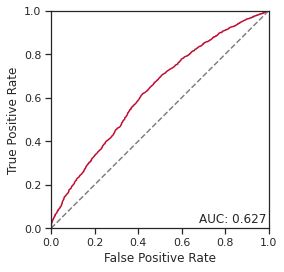

In [163]:
plot_roc(results['Base Model']['dfs_mean'][0], figsize=(4,4), output_pdf="roc-base.pdf", show=True)

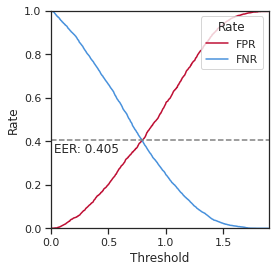

In [175]:
eer = results['Base Model']['eers_mean'][0]
plot_fpr_fnr(results['Base Model']['dfs_mean'][0], eer, figsize=(4,4), output_pdf="fpr-fnr-base.pdf", show=True)

### Big Batch

In [379]:
model_params = models[0]
model = load_model(model_params, 'final')
samples, labels = get_dataset_batch(model_params['dataset'], model_params['downsampling'], bigbatch=True)
embeddings = get_embeddings(model, samples)
nums_anchors = [1, 2, 4, 8, 16, 32]
dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min = get_roc_data(embeddings, labels, nums_anchors, 10)

100%|██████████| 1000/1000 [00:00<00:00, 42057.86it/s]


In [380]:
print("| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |")
print("| ------------------- | --------- | --------- | ---------- | ---------- |")
for num_anchors, auc_min, eer_min, auc_mean, eer_mean in zip(nums_anchors, aucs_min, eers_min, aucs_mean, eers_mean):
    print(f"| {num_anchors:19} | {auc_min:9.3f} | {eer_min:9.3f} | {auc_mean:10.3f} | {eer_mean:10.3f} |")

| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |
| ------------------- | --------- | --------- | ---------- | ---------- |
|                   1 |     0.627 |     0.405 |      0.627 |      0.405 |
|                   2 |     0.637 |     0.404 |      0.647 |      0.388 |
|                   4 |     0.651 |     0.395 |      0.670 |      0.373 |
|                   8 |     0.665 |     0.383 |      0.689 |      0.358 |
|                  16 |     0.661 |     0.385 |      0.698 |      0.350 |
|                  32 |     0.630 |     0.402 |      0.675 |      0.367 |


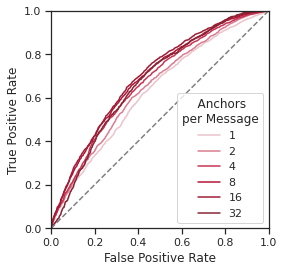

In [382]:
plot_roc_multiple(dfs_mean, hue_label="    Anchors\nper Message", figsize=(4,4), output_pdf="roc-mean.pdf", show=True)

### Magnitude

We once again use the results from earlier.

In [195]:
results_magnitude = []
for percentage in range(10, 100, 10):
    results_magnitude.append(dict(
        percentage=percentage,
        auc=results[f"{percentage}%"]['aucs_mean'][0],
        eer=results[f"{percentage}%"]['eers_mean'][0],
    ))
results_magnitude.append(dict(
    percentage=100,
    auc=results['Base Model']['aucs_mean'][0],
    eer=results['Base Model']['eers_mean'][0],
))

In [206]:
print("| Dataset Size (%) | AUC    | EER    |")
print("| ---------------- | ------ | ------ |")
for r in results_magnitude:
    print(f"| {r['percentage']:16} | {r['auc']:6.3f} | {r['eer']:6.3f} |")

| Dataset Size (%) | AUC    | EER    |
| ---------------- | ------ | ------ |
|               10 |  0.581 |  0.443 |
|               20 |  0.586 |  0.448 |
|               30 |  0.638 |  0.407 |
|               40 |  0.623 |  0.416 |
|               50 |  0.607 |  0.430 |
|               60 |  0.622 |  0.415 |
|               70 |  0.605 |  0.426 |
|               80 |  0.600 |  0.432 |
|               90 |  0.596 |  0.438 |
|              100 |  0.627 |  0.405 |


In [200]:
@plot
def plot_results_magnitude(results_magnitude, figsize=(6, 6)):
    df_results = pd.DataFrame(results_magnitude)
    df_results = df_results.sort_values(by='percentage')

    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x='percentage', y='auc', data=df_results, ax=ax)
    #sns.lineplot(x='percentage', y='auc', data=df_results, ax=ax, label='AUC')
    #sns.lineplot(x='percentage', y='eer', data=df_results, ax=ax, label='EER')
    ax.set(xlabel='Dataset Size (%)', ylabel='ROC AUC')
    ax.set_xticks(df_results['percentage'])
    #ax.set(xlim=(0, 100), ylim=(0, 1))
    #ax.set_box_aspect(1)
    #sns.move_legend(ax, 'upper right')

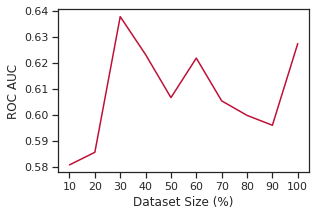

In [204]:
plot_results_magnitude(results_magnitude, figsize=(4.5,3), output_pdf="reduced-dataset.pdf", show=True)

### Time Gap

#### Old vs Fresh Anchors

In [388]:
model_params = models[0]
model = load_model(model_params, 'final')

In [389]:
samples_old, labels_old = get_dataset_batch(model_params['dataset'], model_params['downsampling'])
samples_fresh, labels_fresh, timestamps_fresh = load_database(os.path.join(data_base, 'db-1e.sqlite3'))
np.random.seed(2023)
idx = np.random.choice(len(samples_fresh), size=len(samples_old), replace=False)
samples_fresh = samples_fresh[idx]
labels_fresh = labels_fresh[idx]
timestamps_fresh = timestamps_fresh[idx]

100%|█████████▉| 43608/43644 [00:08<00:00, 4892.72it/s]


In [390]:
embeddings_old = get_embeddings(model, samples_old)
embeddings_fresh = get_embeddings(model, samples_fresh)
embeddings = np.concatenate((embeddings_old, embeddings_fresh))
distances = get_distances(embeddings)
# Take only the distances between old and fresh samples
distances = distances[:len(samples_old), len(samples_old):]
distances_same_old = distances[labels_old[:, None] == labels_fresh]
distances_diff_old = distances[labels_old[:, None] != labels_fresh]
df_statistical_old = get_statistical_data(distances_same_old, distances_diff_old)

100%|██████████| 1000/1000 [01:06<00:00, 14.97it/s]


In [391]:
auc = roc_auc(df_statistical_old)
print(f'AUC: {auc:.3f}')
eer = find_eer(distances_same_old, distances_diff_old)
print(f'EER: {eer:.3f}')

AUC: 0.580
EER: 0.444


In [392]:
distances = get_distances(embeddings_fresh)
distances_same_fresh, distances_diff_fresh = get_distances_same_diff(distances, labels_fresh)
df_statistical_fresh = get_statistical_data(distances_same_fresh, distances_diff_fresh)

100%|██████████| 1000/1000 [01:06<00:00, 14.99it/s]


In [393]:
auc = roc_auc(df_statistical_fresh)
print(f'AUC: {auc:.3f}')
eer = find_eer(distances_same_fresh, distances_diff_fresh)
print(f'EER: {eer:.3f}')

AUC: 0.615
EER: 0.422


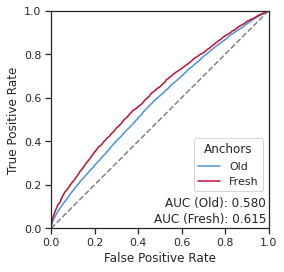

In [394]:
plot_roc_a_b(df_statistical_old, df_statistical_fresh, "Old", "Fresh", figsize=(4,4), output_pdf='roc-anchor-timediff.pdf', show=True)

In [395]:
samples, labels, timestamps = load_database(os.path.join(data_base, 'db-1e.sqlite3'))

labels_unique, labels_counts = np.unique(labels, return_counts=True)
idx = np.isin(labels, labels_unique[labels_counts > (group_window_size_bigbatch // 2)])
idx = np.argsort(labels_counts)[::-1]
labels_unique = labels_unique[idx]
labels_counts = labels_counts[idx]
# Get first n labels such that the sum of their counts is less than 5000
idx = np.cumsum(labels_counts) < 5000
labels_unique = labels_unique[idx]
labels_counts = labels_counts[idx]

idx = np.isin(labels, labels_unique)
samples = samples[idx]
labels = labels[idx]
timestamps = timestamps[idx]

100%|█████████▉| 43608/43644 [00:08<00:00, 4950.28it/s]


In [396]:
embeddings = get_embeddings(model, samples)
nums_anchors = [1, 2, 4, 8, 16, 32]
dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min = get_roc_data(embeddings, labels, nums_anchors, 10)

100%|██████████| 1000/1000 [00:00<00:00, 2692.80it/s]


In [397]:
print("| Samples per test | AUC (min) | EER (min) | AUC (mean) | EER (mean) |")
print("| ---------------- | --------- | --------- | ---------- | ---------- |")
for num_anchors, auc_min, eer_min, auc_mean, eer_mean in zip(nums_anchors, aucs_min, eers_min, aucs_mean, eers_mean):
    print(f"| {num_anchors:16} | {auc_min:9.3f} | {eer_min:9.3f} | {auc_mean:10.3f} | {eer_mean:10.3f} |")

| Samples per test | AUC (min) | EER (min) | AUC (mean) | EER (mean) |
| ---------------- | --------- | --------- | ---------- | ---------- |
|                1 |     0.587 |     0.438 |      0.587 |      0.438 |
|                2 |     0.611 |     0.419 |      0.612 |      0.418 |
|                4 |     0.637 |     0.402 |      0.639 |      0.399 |
|                8 |     0.647 |     0.395 |      0.654 |      0.387 |
|               16 |     0.653 |     0.389 |      0.661 |      0.381 |
|               32 |     0.659 |     0.385 |      0.666 |      0.378 |


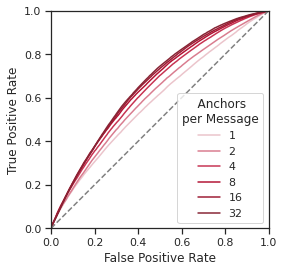

In [400]:
plot_roc_multiple(dfs_mean, hue_label="    Anchors\nper Message", figsize=(4,4), output_pdf='roc-anchor-timediff-fresh-multiple.pdf', show=True)

In [172]:
unload_model(model)
del model
del samples, labels, timestamps, embeddings, dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min, df_statistical

#### Anchor Timediff vs Performance

In [173]:
model_params = models[0]
model = load_model(model_params, 'final')

In [174]:
dbs = [ f'db-{suffix}.sqlite3' for suffix in
    ['v', 'w', 'x', 'y', 'z', '1a', '1b', '1c', '1d', '1e']
]

timestamp_min = None
timestamp_max = None
num_messages = 0
samples_arrays = []
labels_arrays = []
timestamps_arrays = []

subset = 1000
for db in dbs:
    samples, labels, timestamps = load_database(os.path.join(data_base, db))

    num_messages += len(samples)
    timestamp_min = min(timestamp_min, min(timestamps)) if timestamp_min else min(timestamps)
    timestamp_max = max(timestamp_max, max(timestamps)) if timestamp_max else max(timestamps)

    idx = np.random.choice(len(samples), size=subset, replace=False)
    samples_arrays.append(samples[idx])
    labels_arrays.append(labels[idx])
    timestamps_arrays.append(timestamps[idx])

    del samples, labels, timestamps

samples = np.concatenate(samples_arrays)
labels = np.concatenate(labels_arrays)
timestamps = np.concatenate(timestamps_arrays)

100%|█████████▉| 43608/43644 [00:08<00:00, 5033.12it/s]


In [68]:
print(f"Total messages: {num_messages}")
timestamp_diff = timestamp_max - timestamp_min
print(f"Time range: {timestamp_diff.days} days, {timestamp_diff.seconds // 3600} hours, {timestamp_diff.seconds % 3600 // 60} minutes, {timestamp_diff.seconds % 60} seconds")

Total messages: 694738
Time range: 16 days, 21 hours, 51 minutes, 9 seconds


In [175]:
embeddings = get_embeddings(model, samples)

In [176]:
distances = get_distances(embeddings)
timediffs = timestamps[:, np.newaxis] - timestamps[np.newaxis, :]

In [177]:
def get_distances_timediffs_same_diff(distances, labels, timediffs):
    """
    Split the given distances/timediffs into same and different classes.

    Args:
        distances (np.ndarray): Distances to split.
        labels (np.ndarray): Labels for the distances.
        timediffs (np.ndarray): Timediffs for the distances.
    """
    mask = np.zeros(distances.shape, dtype=bool)
    np.fill_diagonal(mask, True)
    mask = mask | np.tri(*mask.shape, dtype=bool)
    mask = ~mask

    distances_same = distances[(labels[:, None] == labels) & mask]
    distances_diff = distances[labels[:, None] != labels]
    timediffs_same = timediffs[(labels[:, None] == labels) & mask]
    timediffs_diff = timediffs[labels[:, None] != labels]

    return distances_same, distances_diff, timediffs_same, timediffs_diff

In [178]:
distances_same, distances_diff, timediffs_same, timediffs_diff = get_distances_timediffs_same_diff(distances, labels, timediffs)

In [179]:
idx = np.random.choice(len(distances_diff), size=len(distances_same), replace=False)

timediffs_same_hours = np.array([ abs(t.total_seconds() / 3600) for t in timediffs_same ])
timediffs_diff_hours = np.array([ abs(t.total_seconds() / 3600) for t in timediffs_diff ])

ds_same = pd.DataFrame({
    'distances': distances_same,
    'timediffs': timediffs_same_hours,
    'label': 'Same'
})
ds_diff = pd.DataFrame({
    'distances': distances_diff[idx],
    'timediffs': timediffs_diff_hours[idx],
    'label': 'Different'
})
ds = pd.concat([ds_same, ds_diff])
ds.index = np.arange(len(ds))

In [195]:
@plot
def plot_timediffs(data, margin=0.05):
    ds['Label'] = ds['label']
    xlim = (ds['timediffs'].min(), ds['timediffs'].max())
    ylim = (ds['distances'].min(), ds['distances'].max())
    xlim = (xlim[0] - margin * (xlim[1] - xlim[0]), xlim[1] + margin * (xlim[1] - xlim[0]))
    ylim = (ylim[0] - margin * (ylim[1] - ylim[0]), ylim[1] + margin * (ylim[1] - ylim[0]))
    h = sns.jointplot(
        data=ds,
        x='timediffs',
        y='distances',
        hue='Label',
        hue_order=['Same', 'Different'],
        xlim=xlim,
        ylim=ylim,
        joint_kws=dict(alpha=0.1, rasterized=True)
    )
    h.set_axis_labels('Time difference (hours)', 'Distance')

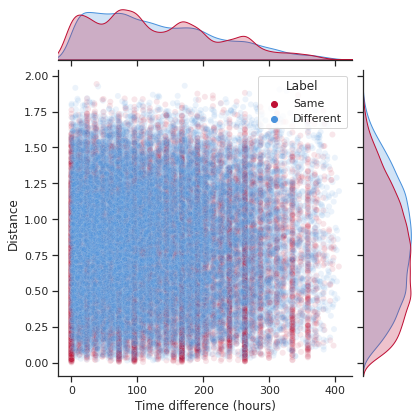

In [198]:
plot_timediffs(ds, output_pdf="timediffs.pdf", dpi=150, show=True)

In [131]:
del ds_same, ds_diff, ds
unload_model(model)
del model

### Removed Transmitters

In [274]:
model_params = [ m for m in models if m['name'].endswith('ids-removed') ][0]
model = load_model(model_params, 'final')

In [281]:
dataset_params_train = 'ids-removed-train'
dataset_params_test = 'ids-removed-test'

samples_train, labels_train = get_dataset_all(dataset_params_train, model_params['downsampling'])
samples_test, labels_test = get_dataset_all(dataset_params_test, model_params['downsampling'])

#embeddings_train = get_embeddings(model, samples_train)
#embeddings_test = get_embeddings(model, samples_test)

In [291]:
# Reduce samples_train to only labels that have more than 16 samples
labels_train_unique, labels_train_counts = np.unique(labels_train, return_counts=True)
idx = np.where(labels_train_counts > 16)[0]
labels_train_unique = labels_train_unique[idx]
labels_train_counts = labels_train_counts[idx]
idx = np.isin(labels_train, labels_train_unique)
samples_train = samples_train[idx]
labels_train = labels_train[idx]

In [292]:
# For each ID in samples_test, take the first 64 samples
samples_test_reduced = []
labels_test_reduced = []
for label in np.unique(labels_test):
    idx = np.where(labels_test == label)[0]
    idx = idx[:64]
    samples_test_reduced.append(samples_test[idx])
    labels_test_reduced.append(labels_test[idx])

samples_test_reduced = np.concatenate(samples_test_reduced)
labels_test_reduced = np.concatenate(labels_test_reduced)

In [293]:
embeddings_train = get_embeddings(model, samples_train)
embeddings_test = get_embeddings(model, samples_test_reduced)

In [305]:
nums_anchors = [1, 2, 4, 8, 16]
dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min = get_roc_data(embeddings_train, labels_train, nums_anchors, 10)

df_train = dfs_mean[-1]
auc_train = aucs_mean[-1]
eer_train = eers_mean[-1]

100%|██████████| 1000/1000 [00:00<00:00, 2487.83it/s]


In [306]:
print("| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |")
print("| ------------------- | --------- | --------- | ---------- | ---------- |")
for num_anchors, auc_min, eer_min, auc_mean, eer_mean in zip(nums_anchors, aucs_min, eers_min, aucs_mean, eers_mean):
    print(f"| {num_anchors:19} | {auc_min:9.3f} | {eer_min:9.3f} | {auc_mean:10.3f} | {eer_mean:10.3f} |")

| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |
| ------------------- | --------- | --------- | ---------- | ---------- |
|                   1 |     0.566 |     0.455 |      0.566 |      0.455 |
|                   2 |     0.587 |     0.442 |      0.588 |      0.439 |
|                   4 |     0.604 |     0.428 |      0.604 |      0.428 |
|                   8 |     0.622 |     0.415 |      0.621 |      0.417 |
|                  16 |     0.635 |     0.416 |      0.637 |      0.407 |


In [307]:
nums_anchors = [1, 2, 4, 8, 16]
dfs_mean, dfs_min, aucs_mean, aucs_min, eers_mean, eers_min = get_roc_data(embeddings_test, labels_test_reduced, nums_anchors, 10)

df_test = dfs_mean[-1]
auc_test = aucs_mean[-1]
eer_test = eers_mean[-1]

100%|██████████| 1000/1000 [00:00<00:00, 4763.30it/s]


In [308]:
print("| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |")
print("| ------------------- | --------- | --------- | ---------- | ---------- |")
for num_anchors, auc_min, eer_min, auc_mean, eer_mean in zip(nums_anchors, aucs_min, eers_min, aucs_mean, eers_mean):
    print(f"| {num_anchors:19} | {auc_min:9.3f} | {eer_min:9.3f} | {auc_mean:10.3f} | {eer_mean:10.3f} |")

| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) |
| ------------------- | --------- | --------- | ---------- | ---------- |
|                   1 |     0.546 |     0.468 |      0.546 |      0.468 |
|                   2 |     0.555 |     0.463 |      0.558 |      0.459 |
|                   4 |     0.574 |     0.451 |      0.571 |      0.452 |
|                   8 |     0.582 |     0.442 |      0.577 |      0.445 |
|                  16 |     0.593 |     0.436 |      0.587 |      0.439 |


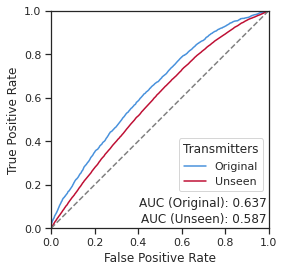

In [405]:
plot_roc_a_b(df_train, df_test, "Original", "Unseen", legend_title="Transmitters", figsize=(4,4), output_pdf="roc-anchor-removed-transmitters.pdf", show=True)

### Replay Attack

In [312]:
model_params = models[0]
model = load_model(model_params, 'final')

In [313]:
samples_replay, labels_replay, _ = load_database(os.path.join(data_base, 'replay-attack', 'db-1.sqlite3'))

100%|█████████▉| 209/210 [00:00<00:00, 4637.09it/s]


In [314]:
samples_test = []
labels_test = []

dbs = [
    "db-1a.sqlite3",
    "db-1b.sqlite3",
    "db-1c.sqlite3",
    "db-1d.sqlite3",
    "db-1e.sqlite3"
]

for db in dbs:
    samples, labels, _ = load_database(os.path.join(data_base, db))

    # Select samples from test dataset that have labels in labels_replay
    idx = np.isin(labels, labels_replay)
    samples = samples[idx]
    labels = labels[idx]

    samples_test.append(samples)
    labels_test.append(labels)

    del samples, labels

samples_test = np.concatenate(samples_test)
labels_test = np.concatenate(labels_test)

100%|█████████▉| 43608/43644 [00:09<00:00, 4656.47it/s]


In [315]:
print(f"Testing dataset size: {len(labels_test)}")
np.sort(np.unique(labels_test, return_counts=True)[1])[::-1][:30]

Testing dataset size: 3856


array([242, 191, 174, 172, 147, 141, 137, 137, 131, 128, 128, 126, 126,
       123, 122, 117, 116, 115, 109, 108, 107, 105,  97,  93,  92,  88,
        83,  80,  78,  75])

In [316]:
embeddings_test = get_embeddings(model, samples_test)
embeddings_replay = get_embeddings(model, samples_replay)

embeddings = np.concatenate((embeddings_test, embeddings_replay))

In [323]:
nums_anchors = [1, 2, 4, 8, 16, 32]
dfs_mean, dfs_min, dfs_max, aucs_mean, aucs_min, aucs_max, eers_mean, eers_min, eers_max = get_roc_data_a_b(embeddings_test, labels_test, embeddings_replay, labels_replay, nums_anchors, 10)

100%|██████████| 1000/1000 [00:00<00:00, 8145.02it/s]


In [324]:
print("| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) | AUC (max) | EER (max) |")
print("| ------------------- | --------- | --------- | ---------- | ---------- | --------- | --------- |")
for num_anchors, auc_min, eer_min, auc_mean, eer_mean, auc_max, eer_max in zip(nums_anchors, aucs_min, eers_min, aucs_mean, eers_mean, aucs_max, eers_max):
    print(f"| {num_anchors:19} | {auc_min:9.3f} | {eer_min:9.3f} | {auc_mean:10.3f} | {eer_mean:10.3f} | {auc_max:9.3f} | {eer_max:9.3f} |")

| Anchors per message | AUC (min) | EER (min) | AUC (mean) | EER (mean) | AUC (max) | EER (max) |
| ------------------- | --------- | --------- | ---------- | ---------- | --------- | --------- |
|                   1 |     0.788 |     0.280 |      0.788 |      0.280 |     0.788 |     0.280 |
|                   2 |     0.843 |     0.217 |      0.846 |      0.227 |     0.787 |     0.287 |
|                   4 |     0.885 |     0.166 |      0.885 |      0.176 |     0.777 |     0.292 |
|                   8 |     0.901 |     0.166 |      0.924 |      0.145 |     0.777 |     0.293 |
|                  16 |     0.912 |     0.151 |      0.935 |      0.131 |     0.780 |     0.291 |
|                  32 |     0.920 |     0.146 |      0.946 |      0.120 |     0.772 |     0.291 |


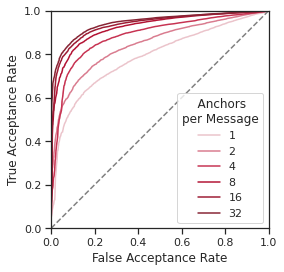

In [331]:
plot_roc_multiple(dfs_mean, hue_label="    Anchors\nper Message", xlabel="False Acceptance Rate", ylabel="True Acceptance Rate", figsize=(4,4), output_pdf="roc-replay-mean.pdf", show=True)

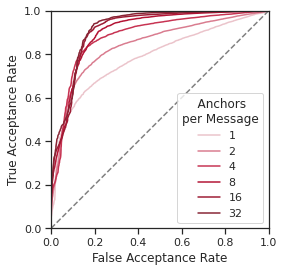

In [333]:
plot_roc_multiple(dfs_min, hue_label="    Anchors\nper Message", xlabel="False Acceptance Rate", ylabel="True Acceptance Rate", figsize=(4,4), output_pdf="roc-replay-min.pdf", show=True)

In [342]:
true_acceptance_rates = [0.999, 0.99, 0.95, 0.90]
false_acceptance_rates = [0.00, 0.01, 0.05, 0.10]

mean_data = []
for t in true_acceptance_rates:
    false_acceptance_rate = dfs_mean[-1][dfs_mean[-1]['tpr'] >= t]['fpr'].min()
    false_acceptance_threshold = dfs_mean[-1][dfs_mean[-1]['tpr'] >= t]['threshold'].min()
    mean_data.append([t, false_acceptance_rate, false_acceptance_threshold])
for f in false_acceptance_rates:
    true_acceptance_rate = dfs_mean[-1][dfs_mean[-1]['fpr'] <= f]['tpr'].max()
    true_acceptance_threshold = dfs_mean[-1][dfs_mean[-1]['fpr'] <= f]['threshold'].max()
    mean_data.append([true_acceptance_rate, f, true_acceptance_threshold])

min_data = []
for t in true_acceptance_rates:
    false_acceptance_rate = dfs_min[-1][dfs_min[-1]['tpr'] >= t]['fpr'].min()
    false_acceptance_threshold = dfs_min[-1][dfs_min[-1]['tpr'] >= t]['threshold'].min()
    min_data.append([t, false_acceptance_rate, false_acceptance_threshold])
for f in false_acceptance_rates:
    true_acceptance_rate = dfs_min[-1][dfs_min[-1]['fpr'] <= f]['tpr'].max()
    true_acceptance_threshold = dfs_min[-1][dfs_min[-1]['fpr'] <= f]['threshold'].max()
    min_data.append([true_acceptance_rate, f, true_acceptance_threshold])


mean_df = pd.DataFrame(mean_data, columns=['True Acceptance Rate', 'False Acceptance Rate', 'Threshold'])
min_df = pd.DataFrame(min_data, columns=['True Acceptance Rate', 'False Acceptance Rate', 'Threshold'])
mean_df['Model'] = 'Mean'
min_df['Model'] = 'Min'

df = pd.concat([mean_df, min_df])

print("| Model | True Acceptance Rate | False Acceptance Rate | Threshold |")
print("| ----- | -------------------- | --------------------- | --------- |")
for model, t, f, th in zip(df['Model'], df['True Acceptance Rate'], df['False Acceptance Rate'], df['Threshold']):
    print(f"| {model:5} | {t:20.4f} | {f:21.4f} | {th:9.4f} |")

| Model | True Acceptance Rate | False Acceptance Rate | Threshold |
| ----- | -------------------- | --------------------- | --------- |
| Mean  |               0.9990 |                0.9779 |    1.3426 |
| Mean  |               0.9900 |                0.8178 |    1.1979 |
| Mean  |               0.9500 |                0.3072 |    1.0547 |
| Mean  |               0.9000 |                0.1500 |    0.9771 |
| Mean  |               0.4236 |                0.0000 |    0.6653 |
| Mean  |               0.6716 |                0.0100 |    0.7951 |
| Mean  |               0.8048 |                0.0500 |    0.8846 |
| Mean  |               0.8606 |                0.1000 |    0.9324 |
| Min   |               0.9990 |                0.8673 |    0.7902 |
| Min   |               0.9900 |                0.4389 |    0.5597 |
| Min   |               0.9500 |                0.2188 |    0.4034 |
| Min   |               0.9000 |                0.1731 |    0.3280 |
| Min   |               0.1741 |  

In [387]:
for i in range(len(mean_data)):
    print(f"& {mean_data[i][0]:.3f} & {mean_data[i][1]:.3f} & {mean_data[i][2]:.3f} & {min_data[i][0]:.3f} & {min_data[i][1]:.3f} & {min_data[i][2]:.3f} \\\\")

& 0.999 & 0.978 & 1.343 & 0.999 & 0.867 & 0.790 \\
& 0.990 & 0.818 & 1.198 & 0.990 & 0.439 & 0.560 \\
& 0.950 & 0.307 & 1.055 & 0.950 & 0.219 & 0.403 \\
& 0.900 & 0.150 & 0.977 & 0.900 & 0.173 & 0.328 \\
& 0.424 & 0.000 & 0.665 & 0.174 & 0.000 & 0.052 \\
& 0.672 & 0.010 & 0.795 & 0.273 & 0.010 & 0.074 \\
& 0.805 & 0.050 & 0.885 & 0.473 & 0.050 & 0.123 \\
& 0.861 & 0.100 & 0.932 & 0.631 & 0.100 & 0.174 \\


In [375]:
@plot
def plot_fpr_fnr_multiple(dfs, figsize=(6, 6), hue=None, hue_label=None, legend_labels=None, palette=None):
    hue_label = hue_label or hue or "Anchors per Message"
    hue = hue or 'Samples per test'
    palette = palette or palette_gradient

    fig, ax = plt.subplots(figsize=figsize)

    df = pd.concat(dfs)
    df.index = range(len(df))

    max_threshold = df['threshold'].max()

    df['FPR'] = df['fpr']
    df['FNR'] = df['fnr']
    df_plot = df.melt(id_vars=['threshold', 'Samples per test'], value_vars=['FPR', 'FNR'], var_name='Rate', value_name='value')
    df_plot['value'] *= 0.998 # Hack to make sure the line is not drawn on the border

    sns.lineplot(x="threshold", y="value", hue="Samples per test", data=df_plot[df_plot['Rate'] == 'FPR'], palette=palette_gradient, ax=ax)
    sns.lineplot(x="threshold", y="value", hue="Samples per test", data=df_plot[df_plot['Rate'] == 'FNR'], palette=palette_gradient_blue, ax=ax)
    #sns.lineplot(x="threshold", y="value", hue="Rate", data=df_plot, ax=ax)
    #sns.despine()
    ax.set(xlabel='Threshold', ylabel='Rate')
    ax.set(xlim=(0, max_threshold), ylim=(0, 1))

    #sns.move_legend(ax, 'lower left')
    legend = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    # Remove first two handles
    handles = handles[5:6] + handles[-1:]
    labels = labels[5:6] + labels[-1:]
    labels = ['False\nAccept', 'False\nReject']
    
    ax.legend(handles=handles, labels=labels, title='Rate', loc='center right')

    ax.set_box_aspect(1)
    
    #ax.plot([0, max_threshold], [eer, eer], color='gray', linestyle='--')

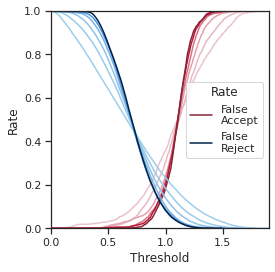

In [377]:
plot_fpr_fnr_multiple(dfs_mean, figsize=(4,4), output_pdf="replay-fpr-fnr-mean.pdf", show=True)

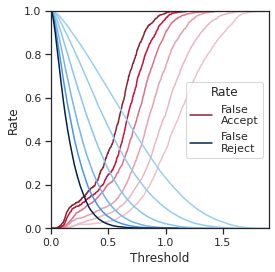

In [378]:
plot_fpr_fnr_multiple(dfs_min, figsize=(4,4), output_pdf="replay-fpr-fnr-min.pdf", show=True)